In [1]:
import torch
from torch import nn , optim
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import h5py
from torch.utils.data import DataLoader, TensorDataset
import cv2
%matplotlib inline

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# Train Data
with h5py.File('train_signs.h5', "r") as train_dataset:
    train_X = np.array(train_dataset["train_set_x"])
    train_X = train_X.reshape(train_X.shape[0] , -1)
    train_X = train_X/255
    
    train_Y = np.array(train_dataset["train_set_y"])
    train_Y = train_Y.reshape(train_Y.shape[0] , 1)

# Test Data
with h5py.File('test_signs.h5', "r") as test_dataset:
    test_X = np.array(test_dataset["test_set_x"])
    test_X = test_X.reshape(test_X.shape[0] , -1)
    test_X = test_X/255
    
    test_Y = np.array(test_dataset["test_set_y"])
    test_Y = test_Y.reshape(test_Y.shape[0] , 1)
    
    classes = np.array(test_dataset["list_classes"])
    
train_X = torch.tensor(train_X , dtype = torch.float)
train_Y = torch.tensor(train_Y , dtype = torch.long)
train_data = TensorDataset(train_X , train_Y)
train_loader = DataLoader(train_data , batch_size = 128 , shuffle = True)

test_X = torch.tensor(test_X , dtype = torch.float)
test_Y = torch.tensor(test_Y , dtype = torch.long)
test_data = TensorDataset(test_X , test_Y)
test_loader = DataLoader(test_data , batch_size = 64 , shuffle = True)

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Linear(12288 , 25)
        self.l2 = nn.Linear(25 , 12)
        self.l3 = nn.Linear(12 , 6)
    
    def forward(self , x):
        x = x.view(x.shape[0] , -1)
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.softmax(self.l3(x) , dim = 1)
        
        return x

In [10]:
model = Classifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr = 0.0001)
model.to(device)

Classifier(
  (l1): Linear(in_features=12288, out_features=25, bias=True)
  (l2): Linear(in_features=25, out_features=12, bias=True)
  (l3): Linear(in_features=12, out_features=6, bias=True)
)

In [11]:
def get_accuracy(model, loader):
    #model.eval()
    num_samples = 0
    num_correct = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            _, preds = y_pred.data.max(1)
            num_samples += preds.size(0)
            num_correct += (y.view(-1) == preds).sum()
        
    return num_correct.item() / num_samples

def train(model, test_loader, train_loader, epochs = 100, print_itr = 10):
    #model.train()
    #costs = []
    for e in range(1, epochs+1):
        if e % print_itr == 0:
            print('Epoch', e, '| Test Accuracy:', get_accuracy(model, test_loader), '| Train Accuracy:', get_accuracy(model, train_loader))
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y.view(-1))
            #costs.append(loss.data[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [12]:
train(model, test_loader, train_loader, epochs=1500 , print_itr = 100) # 96% and 81% accuracy!!

Epoch 100 | Test Accuracy: 0.4583333333333333 | Train Accuracy: 0.43703703703703706
Epoch 200 | Test Accuracy: 0.6916666666666667 | Train Accuracy: 0.674074074074074
Epoch 300 | Test Accuracy: 0.7583333333333333 | Train Accuracy: 0.7564814814814815
Epoch 400 | Test Accuracy: 0.8 | Train Accuracy: 0.8
Epoch 500 | Test Accuracy: 0.8083333333333333 | Train Accuracy: 0.8194444444444444
Epoch 600 | Test Accuracy: 0.825 | Train Accuracy: 0.8388888888888889
Epoch 700 | Test Accuracy: 0.8 | Train Accuracy: 0.8537037037037037
Epoch 800 | Test Accuracy: 0.7833333333333333 | Train Accuracy: 0.8675925925925926
Epoch 900 | Test Accuracy: 0.8166666666666667 | Train Accuracy: 0.8796296296296297
Epoch 1000 | Test Accuracy: 0.8166666666666667 | Train Accuracy: 0.8925925925925926
Epoch 1100 | Test Accuracy: 0.8 | Train Accuracy: 0.8953703703703704
Epoch 1200 | Test Accuracy: 0.8083333333333333 | Train Accuracy: 0.9027777777777778
Epoch 1300 | Test Accuracy: 0.8 | Train Accuracy: 0.9083333333333333
Epoch

In [13]:
def guss_my_image(im_path , input_size = 64):
    im = cv2.imread(im_path)
    im = cv2.resize(im , (input_size , input_size))
    plt.imshow(im)
    im = cv2.cvtColor(im , cv2.COLOR_BGR2RGB)
    im = im.reshape(-1)
    im = im[np.newaxis , ...]/255                                      #Add a channel at 0, thus making it a batch
    im = torch.tensor(im , dtype = torch.float , device = device)
    yhat = model(im)
    _ , number = yhat.data.max(1)
    print(number.data[0])

tensor(1, device='cuda:0')


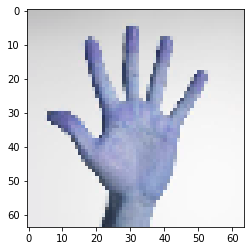

In [14]:
guss_my_image("5.jpg")